<a href="https://colab.research.google.com/github/stephan-strate/sentiment-fine-foods/blob/master/bert_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!pip install -q ktrain

In [54]:
# ensure images directory exists
from pathlib import Path
Path("images").mkdir(parents=True, exist_ok=True)

In [55]:
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 5e-5
MAX_LEN = 128
RANDOM = 42

TU_GREEN = "#639a00"

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import zipfile

url = "https://storage.statc.de/datasets/amazon-fine-food/amazon-fine-food.zip"
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, "r")
zip_file_object.extractall()

In [57]:
df = pd.read_csv("amazon-fine-food-cleaned.csv", delimiter=",", header=0)
print("Dataset has {:,} rows".format(df.shape[0]))

Dataset has 393,670 rows


In [58]:
import math

def calculate_helpfulness(percentage):
  if math.isnan(percentage):
    return -1
  if percentage > 0.5:
    return 1
  return 0

df["Helpfulness"] = (df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"]).apply(calculate_helpfulness)

In [59]:
def calculate_sentiment(score):
  if score > 3:
    return 1
  if score < 3:
    return 0
  return -1

df["Sentiment"] = df["Score"].apply(calculate_sentiment)
df = df[df["Sentiment"] != -1]

print("Removed Score 3 entries, {:,} rows left".format(df_without_neutral.shape[0]))

Removed Score 3 entries, 363,898 rows left


In [60]:
g = df.groupby("Sentiment")
print(g.size())

Sentiment
0     57082
1    306816
dtype: int64


In [61]:
df_balanced = g.apply(lambda x: x.sample(30000).reset_index(drop=True))

In [62]:
import ktrain
from ktrain import text
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced.TextClean.values, df_balanced.Sentiment.values, test_size=0.2, random_state=RANDOM)

t = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, class_names=[0, 1])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=BATCH_SIZE)
learner.fit(LEARNING_RATE, EPOCHS)

preprocessing train...
language: en
train sequence lengths:
	mean : 81
	95percentile : 214
	99percentile : 372


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 80
	95percentile : 214
	99percentile : 378


Epoch 1/2
1500/1500 [==============================] - 662s 441ms/step - loss: 0.2153 - accuracy: 0.9134 - val_loss: 0.1643 - val_accuracy: 0.9360
Epoch 2/2
1500/1500 [==============================] - 661s 441ms/step - loss: 0.1210 - accuracy: 0.9553 - val_loss: 0.1686 - val_accuracy: 0.9364


In [63]:
df_except_training = df[~df.Id.isin(df_balanced.Id.values)]
print(df_except_training.shape[0])

303898


In [64]:
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictions = predictor.predict(df_except_training.TextClean.values)

comparison = list(map(lambda x: x[0] == x[1], zip(predictions, df_except_training.Sentiment.values)))
score = comparison.count(True) / len(df_except_training.Sentiment.values)

print(score)

0.9372486821236072


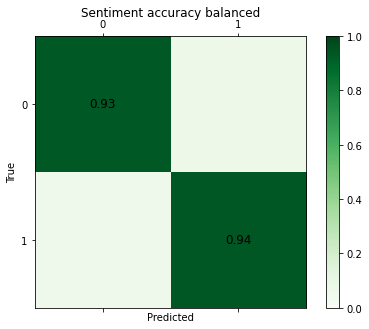

In [65]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df_except_training.Sentiment.values, predictions, [0, 1], normalize="true")

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
for (i, j), z in np.ndenumerate(cm):
    if i == j:
      ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center", fontsize=12)
cax = ax.matshow(cm, cmap=plt.cm.Greens, vmin=0, vmax=1)
fig.colorbar(cax)
ax.set_xticklabels([''] + [0, 1])
ax.set_yticklabels([''] + [0, 1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Sentiment accuracy balanced")

plt.savefig("images/confusion_sentiment_balanced.pdf")
plt.show()

In [66]:
df_test = df[df["TextClean"].isin(df_except_training.TextClean.values)]
print(df_test.shape[0])

303918


In [67]:
gh = df_test.groupby("Helpfulness")
print(gh.size())

Helpfulness
-1    147488
 0     28996
 1    127434
dtype: int64


In [68]:
scores = []
for group_name, group in gh:
  predictions_group = predictor.predict(group.TextClean.values)

  comparison_group = list(map(lambda x: x[0] == x[1] or x[1] == -1, zip(predictions_group, group.Sentiment.values)))
  score_group = comparison_group.count(True) / len(group.Sentiment.values)
  scores.append(score_group)

In [69]:
print(scores)

[0.948090692124105, 0.9018140433163195, 0.9327651961015113]
